In [ ]:
#dataset:  네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus
$ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

In [428]:
import pandas
import konlpy
import gensim
import pandas as pd

#### Naver sentiment movie corpus 데이터

In [359]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### data_loader 및 전처리 처리

In [360]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [361]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [362]:
def load_data(train_data, test_data, num_words=10000): # num_words 추가
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # NaN 결측치 제거
    train_data = train_data.dropna()
    test_data = test_data.dropna()

    X_train = []
    X_test = []

    for sentence in train_data['document']:
        token_X = tokenizer.morphs(sentence) 
        # 불용어(Stopwords) 제거
        token_X = [word for word in token_X if not word in stopwords] 
        X_train.append(token_X)

    for sentence in test_data['document']:
        token_X = tokenizer.morphs(sentence) 
        token_X = [word for word in token_X if not word in stopwords] 
        X_test.append(token_X)

    # 사전 word_to_index 구성
    # 1-dim list
    words = np.concatenate(X_train).tolist()
    count = Counter(words)
    #2를 빼는 이유는 뒤에서 padding(<PAD>)와 unknown(<UNK>) 토큰을 추가할 공간
    vocabulary = dict(count.most_common(num_words-2))

    #빈도수로 index 할당, 0과 1은 padding과 unknown
    word_to_index = {k: v+2 for k, v in vocabulary.items()}
    word_to_index['<PAD>'] = 0
    word_to_index['<UNK>'] = 1

    # Encode 
    def encode(X): 
        result = []
        for line in X:
            lst = []
            for word in line:
                try:
                    lst.append(word_to_index[word])
                except KeyError:
                    lst.append(word_to_index['<UNK>'])
            result.append(lst)
        return result

    X_train = encode(X_train)
    X_test = encode(X_test)

    y_train = np.array(train_data['label'])
    y_test = np.array(test_data['label'])

    return X_train, y_train, X_test, y_test, word_to_index

num_words = 10000 # vocab_size

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words)

In [363]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{159417: '.',
 57340: '영화',
 54973: '다',
 47198: '고',
 44378: '하',
 29834: '을',
 25605: '보',
 22657: '..',
 22163: '게',
 22049: ',',
 19271: '!',
 19140: '지',
 16687: '있',
 15803: '없',
 15325: '?',
 13670: '좋',
 12603: '나',
 12177: '었',
 11671: '만',
 11517: '는데',
 10976: '너무',
 10237: '봤',
 10108: '적',
 10078: '안',
 9753: '정말',
 9647: '로',
 9342: '음',
 9271: '것',
 9100: '아',
 9006: '네요',
 8760: '재밌',
 8744: '어',
 8576: '같',
 8568: '점',
 8363: '지만',
 8302: '진짜',
 8158: '했',
 8073: '에서',
 8057: '기',
 7815: '네',
 7728: '않',
 7683: '거',
 7616: '았',
 7511: '수',
 7471: '되',
 7275: '면',
 7199: 'ㅋㅋ',
 6893: '말',
 6835: '연기',
 6775: '인',
 6575: '주',
 6321: '내',
 6319: '최고',
 6301: '~',
 6250: '평점',
 5996: '이런',
 5904: '던',
 5762: '어요',
 5536: '할',
 5522: '왜',
 5479: '겠',
 5444: '1',
 5421: '스토리',
 5418: '해',
 5347: '습니다',
 5316: 'ㅋㅋㅋ',
 5308: '...',
 5175: '드라마',
 5168: '생각',
 5158: '아니',
 5148: '더',
 5091: '그',
 5048: '싶',
 5036: '사람',
 4992: '듯',
 4830: '때',
 4825: '감동',
 4670: '함',
 4643: '배

####  모델 구성을 위한 데이터 분석 및 가공 (패딩)

max_length: 116
min_length: 0
avg_length: 15.98170773419436


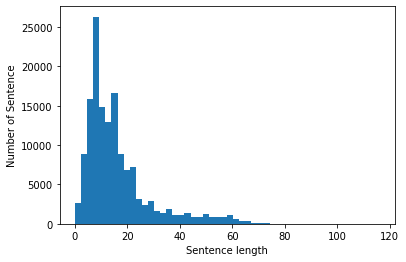

In [364]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentence_lengths = [len(sentence) for sentence in X_train]

max_length = max(sentence_lengths)
min_length = min(sentence_lengths)
avg_length = np.mean(sentence_lengths)
median_length = np.median(sentence_lengths)

print(f"max_length: {max_length}")
print(f"min_length: {min_length}")
print(f"avg_length: {avg_length}")

plt.hist(sentence_lengths, bins=50)
plt.xlabel("Sentence length")
plt.ylabel("Number of Sentence")
plt.show()

In [308]:
# max_len: 각 문장의 길이를 맞추기 위함 (padding)  
# 가장 긴 길이가 116이고, 평균 16자, 최소 길이 0
# trade off: 짧으면 패딩이 많아지고, 많은 패딩은 불필요하게 메모리를 많이 차지한다.
# 문장을 짤라도 되는가? -> 상위 5%의 길이를 계산하여 max_len 설정 (percentile사용)

In [366]:
# vocab_size: 10,000 (모델이 학습할 수 있는 단어 수)
vocab_size = len(word_to_index)
word_vector_dim = 100 

In [367]:
max_len = int(np.percentile(sentence_lengths, 95)) 

In [368]:
max_len

47

In [369]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
padded_X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [370]:
padded_X_train

array([[  9100,   5148,    280, ...,      0,      0,      0],
       [   244, 159417,  22657, ...,      0,      0,      0],
       [ 10976,   1667,      1, ...,      0,      0,      0],
       ...,
       [  2253,      1,  15325, ...,      0,      0,      0],
       [   236,  57340,     73, ...,      0,      0,      0],
       [  1973,  57340,    107, ...,      0,      0,      0]], dtype=int32)

In [371]:
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


decoded_X_train = get_decoded_sentences(padded_X_train, index_to_word)

In [372]:
decoded_X_train[0]

'더 도저히 . . 진짜 짜증 나 네요 똥 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

#### Model 1 :  Bidirectional LSTM

In [316]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout

bidirectional_lstm = keras.Sequential([
    Embedding(vocab_size, word_vector_dim, input_length=max_len),
    
    Bidirectional(LSTM(256, return_sequences=True)),  
    Dropout(0.5), 

    Bidirectional(LSTM(256)), 
    Dropout(0.5), 

    Dense(128, activation='relu'),
    Dropout(0.5), 

    Dense(1, activation='sigmoid')  
])

bidirectional_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bidirectional_lstm.summary()


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 47, 100)           1000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 47, 512)           731136    
_________________________________________________________________
dropout_3 (Dropout)          (None, 47, 512)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)             

In [317]:
print(f"X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"X_test: {len(X_test)}, y_test: {len(y_test)}")

X_train: 146182, y_train: 146182
X_test: 49157, y_test: 49157


In [319]:
from sklearn.model_selection import train_test_split

padded_X_train, padded_X_val, y_train, y_val = train_test_split(padded_X_train, y_train, test_size=0.2, random_state=42)

# 시간제약으로 5에폭만 학습
history = bidirectional_lstm.fit(padded_X_train, y_train, epochs=5, batch_size=32, validation_data=(padded_X_val, y_val))

Epoch 1/5
2924/2924 [==============================] - 56s 18ms/step - loss: 0.4719 - accuracy: 0.7719 - val_loss: 0.4296 - val_accuracy: 0.7920
Epoch 2/5
2924/2924 [==============================] - 51s 17ms/step - loss: 0.4216 - accuracy: 0.8033 - val_loss: 0.4146 - val_accuracy: 0.8008
Epoch 3/5
2924/2924 [==============================] - 51s 17ms/step - loss: 0.4047 - accuracy: 0.8125 - val_loss: 0.4180 - val_accuracy: 0.8025
Epoch 4/5
2924/2924 [==============================] - 51s 17ms/step - loss: 0.3874 - accuracy: 0.8207 - val_loss: 0.4045 - val_accuracy: 0.8134
Epoch 5/5
2924/2924 [==============================] - 51s 17ms/step - loss: 0.3747 - accuracy: 0.8275 - val_loss: 0.4041 - val_accuracy: 0.8113


#### Loss, Accuracy 그래프 시각화


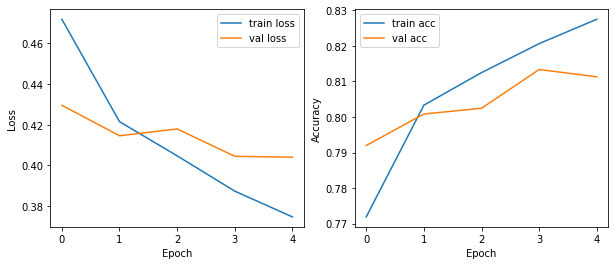

In [320]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  

axes[0].plot(history.history['loss'], label='train loss')
axes[0].plot(history.history['val_loss'], label='val loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='train acc')
axes[1].plot(history.history['val_accuracy'], label='val acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.show()

In [321]:
embedding_layer = bidirectional_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)  

(10000, 100)


In [322]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = '/aiffel/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size, word_vector_dim)) 

10

In [337]:
# 파라미터 저장
word2vec_file_path = '/aiffel/aiffel/sentiment_classification/data/word2vec.txt'

# Embedding 레이어의 가중치 가져오기
vectors = bidirectional_lstm.layers[0].get_weights()[0]  
vocab_size, word_vector_dim = vectors.shape  

with open(word2vec_file_path, 'w') as f:
    for i in range(vocab_size):
        word = index_to_word.get(i, '<UNK>')  # 키가 없는 경우 기본값 사용?
        vector = ' '.join(map(str, vectors[i]))
        f.write(f'{word} {vector}\n')


In [338]:
print("vocab_size:", vocab_size)
print("word_vector_dim:", word_vector_dim)
print("index_to_word example:", list(index_to_word.items())[:5])
print("vectors shape:", vectors.shape)

vocab_size: 10000
word_vector_dim: 100
index_to_word example: [(159417, '.'), (57340, '영화'), (54973, '다'), (47198, '고'), (44378, '하')]
vectors shape: (10000, 100)


In [373]:
print(index_to_word[57340]) 

영화


이후 단어 매칭 이슈 (시간 제약으로 추후 확인 예정)

In [356]:
!pip install optuna

     |████████████████████████████████| 383 kB 5.3 MB/s            
     |████████████████████████████████| 3.1 MB 65.4 MB/s            
     |████████████████████████████████| 233 kB 107.3 MB/s            
     |████████████████████████████████| 78 kB 13.1 MB/s            
     |████████████████████████████████| 597 kB 69.3 MB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.12.2 which i

#### Hyper parameter Optimisation with Optuna 

In [379]:
import optuna

def objective(trial):
    
    lstm_units = trial.suggest_categorical('lstm_units', [64, 128])
    dense_units = trial.suggest_categorical('dense_units', [64, 128])

    bidirectional_lstm = keras.Sequential([
        Embedding(vocab_size, word_vector_dim, input_length=max_len),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(lstm_units)),
        Dropout(0.2),
        Dense(dense_units, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]) 

    bidirectional_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = bidirectional_lstm.fit(
        padded_X_train, y_train,
        epochs=5,  
        batch_size=32,  
        validation_data=(padded_X_val, y_val),
        verbose=1
    )

    return history.history['val_loss']

# Optuna study 생성 및 최적화
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=2) 

[I 2025-02-06 06:35:27,887] A new study created in memory with name: no-name-fb4321f6-6b76-4b7b-b142-037e4bcf9c6d


Epoch 1/5
4569/4569 [==============================] - 64s 13ms/step - loss: 0.4459 - accuracy: 0.7863 - val_loss: 0.4023 - val_accuracy: 0.8119
Epoch 2/5
4569/4569 [==============================] - 58s 13ms/step - loss: 0.4053 - accuracy: 0.8094 - val_loss: 0.3823 - val_accuracy: 0.8230
Epoch 3/5
4569/4569 [==============================] - 58s 13ms/step - loss: 0.3869 - accuracy: 0.8211 - val_loss: 0.3600 - val_accuracy: 0.8333
Epoch 4/5
4569/4569 [==============================] - 58s 13ms/step - loss: 0.3714 - accuracy: 0.8288 - val_loss: 0.3457 - val_accuracy: 0.8448
Epoch 5/5
4569/4569 [==============================] - 58s 13ms/step - loss: 0.3559 - accuracy: 0.8366 - val_loss: 0.3270 - val_accuracy: 0.8516


[W 2025-02-06 06:40:24,692] Trial 0 failed with parameters: {'lstm_units': 128, 'dense_units': 128} because of the following error: The number of the values 5 did not match the number of the objectives 1.
[W 2025-02-06 06:40:24,693] Trial 0 failed with value [0.40226805210113525, 0.3822777271270752, 0.3599993884563446, 0.34571167826652527, 0.3269590139389038].


Epoch 1/5
4569/4569 [==============================] - 65s 13ms/step - loss: 0.4462 - accuracy: 0.7853 - val_loss: 0.3980 - val_accuracy: 0.8117
Epoch 2/5
4569/4569 [==============================] - 58s 13ms/step - loss: 0.4037 - accuracy: 0.8107 - val_loss: 0.3751 - val_accuracy: 0.8276
Epoch 3/5
4569/4569 [==============================] - 58s 13ms/step - loss: 0.3852 - accuracy: 0.8209 - val_loss: 0.3652 - val_accuracy: 0.8361
Epoch 4/5
4569/4569 [==============================] - 58s 13ms/step - loss: 0.3716 - accuracy: 0.8280 - val_loss: 0.3466 - val_accuracy: 0.8390
Epoch 5/5
4569/4569 [==============================] - 58s 13ms/step - loss: 0.3567 - accuracy: 0.8360 - val_loss: 0.3307 - val_accuracy: 0.8489


[W 2025-02-06 06:45:21,982] Trial 1 failed with parameters: {'lstm_units': 128, 'dense_units': 64} because of the following error: The number of the values 5 did not match the number of the objectives 1.
[W 2025-02-06 06:45:21,983] Trial 1 failed with value [0.3980025053024292, 0.3751060962677002, 0.3652075231075287, 0.3465943932533264, 0.3306749165058136].


In [ ]:
# number of trials를 충분히 설정후 학습후 확인 가능(시간제약 이슈로 생략)
trial = study.best_trial
print(f'  Params: {trial.params}')  

#### 다른 모델들  (Parallel Conv1D, Sequential Conv1D)

In [418]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
import time

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(vocab_size, word_vector_dim, input_length=max_len)(input_layer)

# 병렬 Conv1D 처리 방식
conv1 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(embedding_layer)
pool1 = GlobalMaxPooling1D()(conv1)

conv2 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(embedding_layer)
pool2 = GlobalMaxPooling1D()(conv2)

conv3 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(embedding_layer)
pool3 = GlobalMaxPooling1D()(conv3)

# Merge
merged = Concatenate()([pool1, pool2, pool3])

dense1 = Dense(128, activation='relu')(merged)
dropout = Dropout(0.2)(dense1)
output_layer = Dense(1, activation='sigmoid')(dropout)

model2 = Model(inputs=input_layer, outputs=output_layer)
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 47)]         0                                            
__________________________________________________________________________________________________
embedding_65 (Embedding)        (None, 47, 128)      1280000     input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, 47, 128)      49280       embedding_65[0][0]               
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, 47, 128)      49280       embedding_65[0][0]               
____________________________________________________________________________________________

In [419]:
start_time = time.time()
history2 = model2.fit(
    padded_X_train, y_train,
    epochs=5,  
    batch_size=32,  
    validation_data=(padded_X_val, y_val),
    verbose=1
)
end_time = time.time()
train_time = end_time - start_time
print(f"time: {train_time:.4f}s")

Epoch 1/5
4569/4569 [==============================] - 25s 5ms/step - loss: 0.4332 - accuracy: 0.7921 - val_loss: 0.3746 - val_accuracy: 0.8270
Epoch 2/5
4569/4569 [==============================] - 24s 5ms/step - loss: 0.3763 - accuracy: 0.8252 - val_loss: 0.3314 - val_accuracy: 0.8556
Epoch 3/5
4569/4569 [==============================] - 24s 5ms/step - loss: 0.3369 - accuracy: 0.8477 - val_loss: 0.2713 - val_accuracy: 0.8826
Epoch 4/5
4569/4569 [==============================] - 24s 5ms/step - loss: 0.2988 - accuracy: 0.8676 - val_loss: 0.2321 - val_accuracy: 0.9029
Epoch 5/5
4569/4569 [==============================] - 25s 5ms/step - loss: 0.2589 - accuracy: 0.8865 - val_loss: 0.1961 - val_accuracy: 0.9181
time: 122.1529s


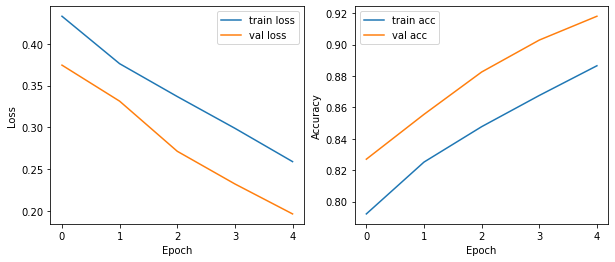

In [420]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  

axes[0].plot(history2.history['loss'], label='train loss')
axes[0].plot(history2.history['val_loss'], label='val loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history2.history['accuracy'], label='train acc')
axes[1].plot(history2.history['val_accuracy'], label='val acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.show()

문장이 길고 문맥이 중요한 경우, BiLSTM은 유리한 모델입니다.
그럼에도 불구하고 Conv1D가 더 나은 결과를 보일 수 있었던 이유를 예측해보면
1. 영화 리뷰 자체가 짧은 문장이나 간결한 문장
2. 영화 리뷰에서 감정 키워드 (local features)을 잘 추출
3. 전처리 이슈 가능성도 있음

각 Conv1D 레이어 파라미터 개수 = (kernel_size * input_channels * output_channels) + output_channels     

1. 파라미터 수=(3×128+128)×128=49,152   
총 파라미터 수= Embedding 파라미터 수 + conv3(3) × param(49152) + Dense1(49280) + Dense2(129)


#### Conv1D Sequential

In [412]:
# Sequential 
model3 = Sequential([
    Embedding(vocab_size, word_vector_dim, input_length=max_len),  # (batch_size, sequence_length, embedding_dim)
    
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    GlobalMaxPooling1D(),  
    
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


model3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_63 (Embedding)     (None, 47, 128)           1280000   
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 47, 128)           49280     
_________________________________________________________________
global_max_pooling1d_38 (Glo (None, 128)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 129       
Total params: 1,345,921
Trainable params: 1,345,921
Non-trainable params: 0
___________________________________________

In [415]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

start_time = time.time()

history3 = model3.fit(
    padded_X_train, y_train,
    epochs=5,  
    batch_size=32,  
    validation_data=(padded_X_val, y_val),
    verbose=1
)
end_time = time.time()
train_time = end_time - start_time
print(f"time: {train_time:.4f}s")

Epoch 1/5
4569/4569 [==============================] - 17s 4ms/step - loss: 0.2436 - accuracy: 0.8939 - val_loss: 0.1837 - val_accuracy: 0.9277
Epoch 2/5
4569/4569 [==============================] - 18s 4ms/step - loss: 0.2154 - accuracy: 0.9065 - val_loss: 0.1812 - val_accuracy: 0.9361
Epoch 3/5
4569/4569 [==============================] - 18s 4ms/step - loss: 0.1932 - accuracy: 0.9158 - val_loss: 0.1377 - val_accuracy: 0.9440
Epoch 4/5
4569/4569 [==============================] - 17s 4ms/step - loss: 0.1742 - accuracy: 0.9248 - val_loss: 0.1298 - val_accuracy: 0.9504
Epoch 5/5
4569/4569 [==============================] - 17s 4ms/step - loss: 0.1579 - accuracy: 0.9309 - val_loss: 0.1190 - val_accuracy: 0.9522
time: 141.9727s


각 Conv1D 레이어 파라미터 개수 = (kernel_size * input_channels * output_channels) + output_channels     

1. 파라미터 수=(3×128+128)×128=49,152   
총 파라미터 수= Embedding 파라미터 수 + param(49152) + Dense1(16,512) + Dense2(129)


#### 6) Loss, Accuracy 그래프 시각화


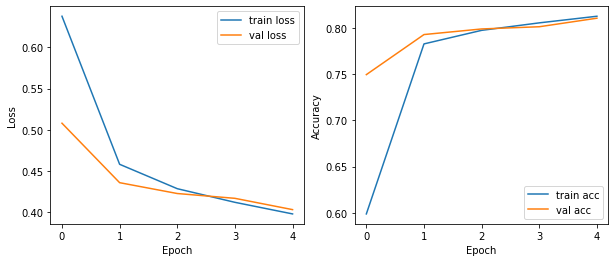

In [273]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  

axes[0].plot(history.history['loss'], label='train loss')
axes[0].plot(history.history['val_loss'], label='val loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='train acc')
axes[1].plot(history.history['val_accuracy'], label='val acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.show()

#### 한국어 Word2Vec 임베딩 활용하여 성능 개선


In [424]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/aiffel/data/word2vec_ko.model'
word2vec_model = Word2VecKeyedVectors.load(word2vec_file_path)

In [429]:
embedding_dim = word2vec_model.vector_size  
# Initialize
embedding_matrix = np.zeros((vocab_size, embedding_dim)) 
# 시간초과 ㅠ

#### Error report

에러 발생 원인:   
Conv1D와 MaxPooling1D 레이어의 입력 및 출력 크기를 고려하지 못한 문제   

Conv1D 레이어의 출력 크기가 42에서 MaxPooling1D 레이어로 pool_size 5로 다운샘플링 하면 42 / 5 = 8.4로 소수점이 발생. MaxPooling1D 레이어는 정수 단위로만 처리가 가능하므로, 이 과정에서 에러가 발생

해결 방법:   
Conv1D 레이어와 MaxPooling1D 레이어의 연산을 고려하여 설정필요.

